# Group 4 Final Project 

1. Anvi Jain - jain.anv@northeastern.edu - 002657150
2. Abhishek Shankar - shankar.abhi@northeastern.edu - 002751339
3. Shobith Sivadas - sivadas.s@northeastern.edu - 002775754



# About the coprus

Data Science is a complex and wonderful subject. This Fall semester has definitely been a rollercoaster in Prof Dino's Class without whom this subject would have not been so much fun to learn. We've learned all sorts of concepts ranging from simple to complex probability , foundations for machine learning and lets not forget who the best  Forumla 1 driver and pop artists are. 

Lets apply some concepts we've learned to analyse what were some of the key moments this semester. We have taken the Zoom transcripts from all of the professors classes into various corpuses. In total we have 20 classes comprising of over 5000 sentences. Each Zoom call transcript has been split into the classes we obtained it from. 

## Constraints
One major constraint here was the output of Zoom call speech to text API. The sentences have been mapped correctly 90% of the time. We have managed to fix any descripency possible. 


# Exploratory Data Analysis

We used the following packages for performing EDA
1. NLTK
2. WordCloud
3. Spacy 

Using stopwords from the packages we were able to obtain the corpus to perform  the various analysis.
we are using lrucache to store the function in memory rather then computing the function repeatedly.


In [1]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")
import spacy
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import os
import re
from io import StringIO
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from spacy.lang.en.stop_words import STOP_WORDS
from functools import lru_cache
import timeit
import pickle


def eda(sentences):
    processed_sentences = []

    for s in sentences:
        # Remove all the special characters
        processed_sentence = re.sub(r'\W', ' ', str(s))

        # remove all single characters
        processed_sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

        # Remove single characters from the start
        processed_sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

        # Substituting multiple spaces with single space
        processed_sentence = re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

        # Removing prefixed 'b'
        processed_sentence = re.sub(r'^b\s+', '', processed_sentence)

        # Converting to Lowercase
        processed_sentence = processed_sentence.lower()

        processed_sentences.append(processed_sentence)
        
    return processed_sentences

@lru_cache(maxsize=128) #lru cache is used to cache the function to ensure a single run.
def getData(method):
  wd = os.getcwd()
  transcripts = []
  dino_df = pd.DataFrame()
  km_df = pd.DataFrame()
  dino_ts = {}
  
  cachedStopWords = list(set(stopwords.words("english") + list(STOP_WORDS) + list(STOPWORDS) + ['so data','lot','someone','need','find','unknown','speaker','so data','okay so','so','unknown speaker','actually','many','make','people','ten','go','see','want','yeah','zero','two','three','four','five','six','eight','nine','going','okay','one','say','look','hundred','minus','little','let','um','uh','unknown','right','know','user','avatar','dino','konstantopoulos','yutong','gao']))
  #'sure','little','speaker','things','lot','think','work','way','new','one','number','different','yeah','probability','use','zero','actually' ,'function','say','look','want' ,'okay' ,'let', 'going', 'machine', 'learning', 'data',
  pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')
  pattern2 = r'[0-9]'
  custom = ['so data','lot','someone','need','find','unknown','speaker','so data','okay so','so','unknown speaker','actually','many','make','people','ten','go','see','want','yeah','zero','two','three','four','five','six','eight','nine','going','okay','one','say','look','hundred','minus','little','let','um','uh','unknown','right','know','user','avatar','dino','konstantopoulos','yutong','gao']
  pattern3 = re.compile(r'\b(' + r'|'.join(custom) + r')\b\s*')
  
  
  for files in os.listdir(wd+"\Dino-Until-Nov-21"):
    str1 = open(wd+"\Dino-Until-Nov-21\\"+files, 'r',encoding="utf8").read()   
    StringData = StringIO(str1)
    str1 = str1.lower().replace("so","")
    df = pd.read_csv(StringData, sep ="\n",header=None)
    df['Relevant_Date'] = files.split(".")[0]
    km_df = pd.concat([km_df,df])
    dino_df = pd.concat([dino_df,df])
    str1 = eda([str1])[0]
    str1 = re.sub(pattern,'',str1)
    str1 = re.sub(pattern2,'',str1)  
    str1 = re.sub(pattern3,'',str1)  
    dino_ts[files] = str1
    transcripts.append(str1)
    
  dino = " ".join(map(str, transcripts))  
  
  transcripts = [eda([x])[0] for x in transcripts]
  
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern2, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern3, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(r'[^\w\s]','',x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x : eda([x])[0])
  dino_df = dino_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  dino_df = dino_df[((dino_df.iloc[:,0]!=''))]
  dino_df = dino_df[(dino_df.iloc[:,0].str.split().str.len() > 2)]
  
  
  km_df.iloc[:,0] = km_df.iloc[:,0].apply(lambda x :  re.sub(pattern3, '', x))
  km_df = km_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  km_df = km_df[((km_df.iloc[:,0]!=''))]
  km_df = km_df[(km_df.iloc[:,0].str.split().str.len() > 2)]
  
  corpus = km_df.iloc[:,0].to_list()
  
  #Important Paramter #1
  corpus = list(map(''.join, zip(*([iter(corpus)]*3))))  
  customn = ['so','then','thing','okay','right','um','you']
  for words in customn:
      dino_df.iloc[:,0] = dino_df.iloc[:,0].str.replace(words,"")
 
  if method == "KMedoids":
    return km_df
  elif method == 'EDA':
    return [dino_df,dino_ts,transcripts]

C:\Users\abhis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\abhis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\abhis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\abhis\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


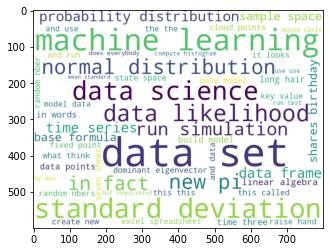

In [2]:

start_time = timeit.default_timer()
'''

Overall Analysis

'''

wd = os.getcwd()


dino_df = getData("EDA")[0]

tfidf = TfidfVectorizer(ngram_range=(2,2))
tfidf_data = tfidf.fit_transform(np.array(dino_df.iloc[:,0]))
df = pd.DataFrame(tfidf_data.toarray(), columns=tfidf.get_feature_names())
word_dict = df.sum(axis=0).to_dict()
df = pd.DataFrame()
df['Words'] = list(word_dict.keys())
df['Sum_Rank_Tf_Idf'] = word_dict.values()
df = df.sort_values('Sum_Rank_Tf_Idf', ascending=False)
med = df.iloc[:10]['Sum_Rank_Tf_Idf'].median()
#df = df[df['Sum_Rank_Tf_Idf']<=(med*.5)]
#    df = df[df['Words']!='corn flakes']

word_dict = {}
for _, row in df.iterrows():
    word_dict[row['Words']] = row['Sum_Rank_Tf_Idf']
    
w = WordCloud(width=800,height=600,mode='RGBA',background_color='white',max_words=50).fit_words(word_dict)
plt.imshow(w)
plt.show()

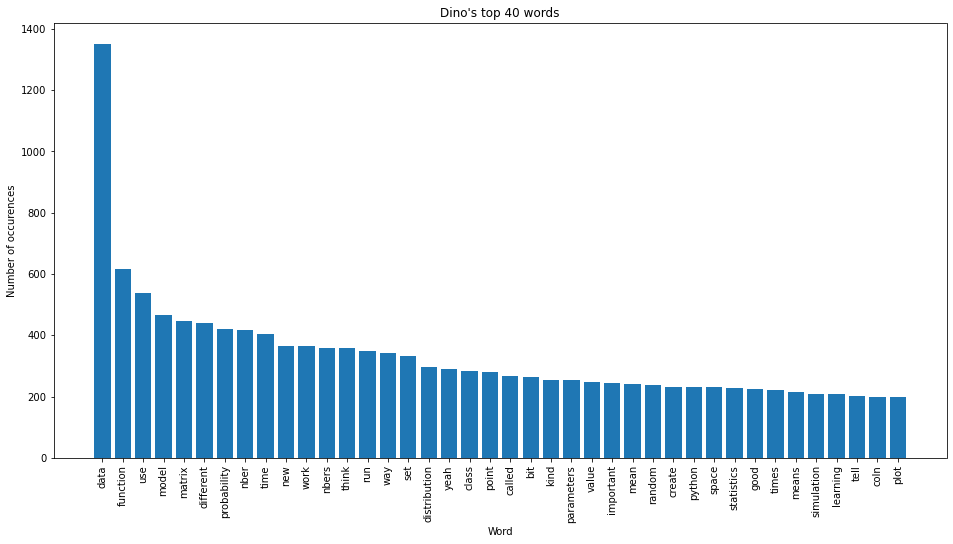

In [3]:
'''

Top N words

'''




def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(dino_df.iloc[:,0], 40):
    words.append(i)
    word_values.append(j)
    
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Dino's top 40 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()


26017   Nov-10.txt
28550   Nov-14.txt
29820   Nov-17.txt
29112   Nov-21.txt
30334   Nov-28.txt
26970   Nov-7.txt
29961   Oct-20.txt
29024   Oct-24.txt
22409   Oct-27.txt
22369   Oct-3.txt
24641   Oct-31.txt
22003   Oct-6.txt
24768   Sep-12.txt
25097   Sep-15.txt
29757   Sep-8.txt
24460   Sept-19.txt
28073   Sept-22.txt
27758   Sept-26.txt
23897   Sept-29.txt


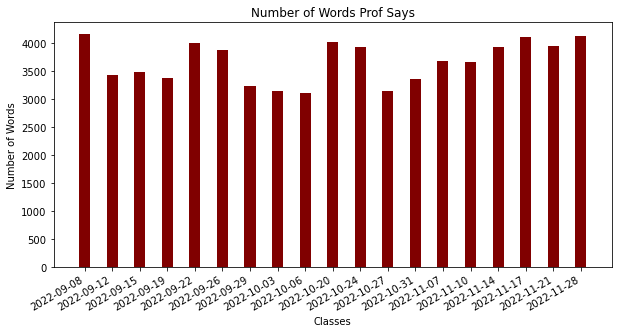

In [4]:
from dateutil  import parser
from collections import OrderedDict
'''

For each class


'''


dino_ts = getData('EDA')[1]
pop_class_ts = {}
for k,v in dino_ts.items():
  #print(k)
  print(len(dino_ts[k])," ",k)
  res = len(re.findall(r'\w+',dino_ts[k]))
  k = k.split(".")[0]
  date1 = "2022-"+k.split("-")[0]+"-"+k.split("-")[-1]
  k = str(parser.parse(k).date())
  pop_class_ts[k] = res

pop_class_ts = dict(OrderedDict(sorted(pop_class_ts.items())))
pd.DataFrame(pop_class_ts,index=[0]).T.reset_index()
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(list(pop_class_ts.keys()), list(pop_class_ts.values()), color ='maroon',
        width = 0.4)
fig.autofmt_xdate()
plt.xlabel("Classes")
plt.ylabel("Number of Words")
plt.title("Number of Words Prof Says")
plt.show()

# KMedoids

For the KMedoids Method, EDA is performed at the top most level, wherein basic punctuations are removed. Data is transformed into vectors and scaled using BERT and PCA.The sentence embedding is a weighted sum of the vectors of words in the sentence.

## Model Training

The corpus is transformed into 384 dimensions with the help of pretrained models in the sentence transoformer model. The model is then saved using a pickle file to disk. This is done to ensure the code runs fast and smooth.


In [5]:
km_df = getData('KMedoids')  
corpus = km_df.iloc[:,0].to_list()
bmodel = SentenceTransformer('all-MiniLM-L6-v2') #384 dims
save_model = False
if save_model:


  #Important Paramter#1

  corpus = list(map(''.join, zip(*([iter(corpus)]*3))))      
  bert_embeddings = bmodel.encode(corpus)
  bert_embeddings.shape
  with open(wd+"\\"+'k_medoids_embedding.pickle', 'wb') as pkl:
      pickle.dump(bert_embeddings, pkl)

with open(wd+"\\"+'k_medoids_embedding.pickle', 'rb') as pkl:
    bert_embeddings = pickle.load(pkl)

print(bert_embeddings.shape)    
bert_embeddings_std = scale(bert_embeddings)  
bert_embeddings_red = PCA(n_components=2).fit_transform(bert_embeddings_std)

h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = bert_embeddings_red[:, 0].min() - 1, bert_embeddings_red[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = bert_embeddings_red[:, 1].min() - 1, bert_embeddings_red[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

(3379, 384)


## Elbow Method

We have employed the use of the Elbow method to find the optimum number of clusters to reduce errors. We found that the curve flattens at the 30 cluster mark. Hence we have taken the number of clusters as 30

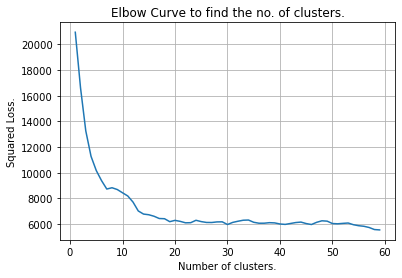

In [6]:
'''

Elbow Method

'''
elbow_method = True

if elbow_method:

  squared_errors = []
  num_cluster = [i for i in range(1,60)]
  for cluster in num_cluster:
      #print(cluster, "Done")
      kmediods = KMedoids(metric="manhattan", n_clusters=cluster, 
           init="heuristic", max_iter=2)
      kmediods.fit(bert_embeddings_red) # Train Cluster
      squared_errors.append(kmediods.inertia_)  # Appending the squared loss obtained in the list
      
  optimal_clusters = np.argmin(squared_errors)# As argmin return the index of minimum loss. 
  plt.plot(num_cluster, squared_errors)
  plt.title("Elbow Curve to find the no. of clusters.")
  plt.xlabel("Number of clusters.")
  plt.ylabel("Squared Loss.")
  plt.grid(True)
  plt.show()

## Choosing the idea Model

We have used 3 Kmedoid models

1. Manhattan
2. Eucledian Distance
3. Cosine Similarity

The graphs have been plotted to visually show us the spread of clusters and  the centroid of each clusters.


<Figure size 432x288 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

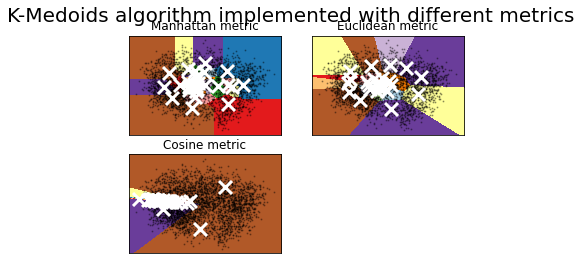

In [7]:
#Important Paramter #2
num_digits = 30

models = [
     (
         KMedoids(metric="manhattan", n_clusters=num_digits, 
         init="heuristic", max_iter=2),"Manhattan metric",
     ),
     (
         KMedoids(metric="euclidean", n_clusters=num_digits,  
         init="heuristic", max_iter=2),"Euclidean metric",
     ),
     (KMedoids(metric="cosine", n_clusters=num_digits, init="heuristic", 
      max_iter=2), "Cosine metric", ),
 ]
models

num_rows = int(np.ceil(len(models) / 2.0))
num_cols = 2 

plt.clf()
plt.figure(figsize=(15,10))
plt.show()

for i, (model, description) in enumerate(models):
    # Fit each point in the mesh to the model
    model.fit(bert_embeddings_red)
    
    #Predict the labels for points in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result  into a color plot
    Z = Z.reshape(xx.shape)
   
    #Subplot for the ith model variant
    plt.subplot(num_cols, num_rows, i + 1)
   
    #Display the subplot
    plt.imshow(
         Z,    #data to be plotted
         interpolation="nearest",
        #bounding box coordinates (left,right,bottom,top)
         extent=(xx.min(), xx.max(), yy.min(), yy.max()),
         cmap=plt.cm.Paired,  #colormap
         aspect="auto", #aspect ratio of the axes
         origin="lower",  #set origin as lower left corner of the axes
    )
    plt.plot(
         bert_embeddings_red[:, 0], bert_embeddings_red[:, 1], "k.", markersize=2, alpha=0.3
    )
        
    # Plot the centroids as white cross marks
    centroids = model.cluster_centers_
    plt.scatter(
         centroids[:, 0],
         centroids[:, 1],
         marker="x",
         s=169,  #marker’s size (points^2)
         linewidths=3, #width of boundary lines
         color="w",  #white color for centroids markings
         zorder=10,  #drawing order of axes
    )
    
    #describing text of the tuple will be title of the subplot
    plt.title(description)  
    plt.xlim(xmin, xmax)  #limits of x-coordinates
    plt.ylim(ymin, ymax)  #limits of y-coordinates
    plt.xticks(())   
    plt.yticks(())
    
#Upper title of the whole plot
plt.suptitle(
    #Text to be displayed
    "K-Medoids algorithm implemented with different metrics\n\n",
    fontsize=20,  #size of the fonts
)
plt.show()

# Final Steps

Now that the clustering has been obtained, we find the centroid of each cluster. This is done to extract the most important strings from the corpus and show us what were the most key takeaways from the lecture with the professor. We noticed that Cosine similarities gave us the best results.

In [8]:

centroids = []
for i, (model, description) in enumerate(models):
    model.fit(bert_embeddings_std)
    centroids.append(model.cluster_centers_)

model_df = {}
for k in range(0,len(models)):
  centroid_indeces = []
  for i in range(num_digits):
      c = centroids[k][i]
      for j in range(bert_embeddings_std.shape[0]):
          if np.allclose(c, bert_embeddings_std[j]):
              centroid_indeces.append(j)
              break      
  words = []            
  for i in centroid_indeces:
     words.append(corpus[i])
     if(k==2):
        print("-------------")
        print(corpus[i])        
        print("-------------")        
  
  model_df['Model_'+str(k+1)] = words

model_df = pd.DataFrame(model_df)   
model_df.to_csv(wd+"\KMedoidsCheck3.csv",index=False)    

 
elapsed = timeit.default_timer() - start_time
print("RUNTIME FOR CODE IS : ", elapsed)

-------------
once you've done your data cleaning You've computed your histogram. You figured out some of the point moments. You have a feel for the data. You at a few rows. Um! You've cleaned up the data. You have your histogram. Now, what
-------------
-------------
You're not patient enough to sit down and . Let me at the problem with driver in show. Then i'll to driver in shows, and i'll to drivers in shows, and i'll to drivers in shows what we
-------------
-------------
and from all these lines you can figure out what the standard deviation is, which is the amount of the the how much uncertain you are about the line, and the mean, which is what your your best guess is for what the the true line looks like.
-------------
-------------
In other words, you can think of. You can think of each Url as a vote that page votes for another page
-------------
-------------
How times do I win If I have a certain percentage of winning in each race. How races will I win? Or ? It's a sequence o